# Paper figures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm.notebook import tqdm, trange
import numpy as np
import torch
import matplotlib.pyplot as plt

import utils
utils.do_svd = False
from notebook.experiments import *
from notebook.plots import *

2024-10-21 00:33:56.011899: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 00:33:56.051388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib as mpl

matplotlib.rcParams.update({
    'text.usetex': True, 
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}\usepackage{subdepth}',
    'font.size': '14',  # Default: 10
    'font.family': 'serif'
})

print(mpl.rcParams)

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: black
axes.labelpad: 4.0
axes.labelsize: medium
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
axes.spines.bottom: True
axes.spines.left: True
axes.spines

## Gaussianity

In [3]:
""" Plots for Scattering J8 on CIFAR. """

def model(w):
    sizes = [int(w * s) for s in [64, 128, 256, 512, 512, 512, 512, 512]]
    arch = "".join(f"WP{s}" for s in sizes)
    return f"cifar-{arch}-norm-L4-clbnstd-clnobias"
pattern = model(1) + "-gaussiantest-init"
exps_dict = exps.load_pattern(pattern, log=False, full_names=True, num=50)
aligned = AlignedExperiments(exps_dict, recompute=False)
ref_exp = aligned.exps_list[0]
exp = aligned.exps_list[1]
key = aligned.keys[1]

Found 50 exps matching cifar-WP64WP128WP256WP512WP512WP512WP512WP512-norm-L4-clbnstd-clnobias-gaussiantest-init
Files already downloaded and verified
Files already downloaded and verified


j=2 r=1 p=0.004165422929427215
j=2 r=10 p=0.4626671326752032
j=2 r=100 p=0.13611453722375
j=4 r=1 p=0.05729563599298304
j=4 r=10 p=0.04459310651276449
j=4 r=100 p=0.15675646012712707
j=6 r=1 p=0.07542010581676928
j=6 r=10 p=0.7558958122868653
j=6 r=100 p=0.48695393098923356


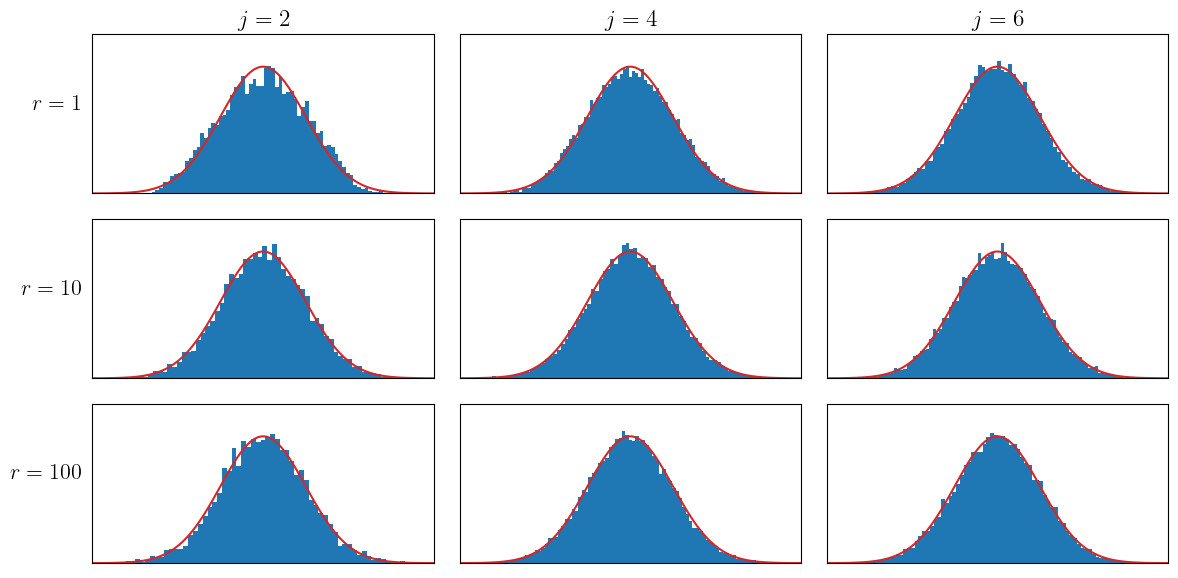

In [5]:
""" Gaussian histograms. """

js = [2, 4, 6]
num_ranks = 3
fig, axs = plt.subplots(figsize=(12, 6), nrows=num_ranks, ncols=len(js))

for col, j in enumerate(js):
    whitened_weights = aligned.whitened_weights(j=j, cat=True)  # (N_tot, R)
    
#     ranks = (whitened_weights.shape[1] ** np.linspace(0, 1, num_ranks + 1)[:num_ranks]).astype(int)
    ranks = [1, 10, 100]
    for row, r in enumerate(ranks):
        plt.sca(axs[row][col])
        
        if r < whitened_weights.shape[1]:
            w = whitened_weights[:, r]
            n = len(w)

            w = w.cpu().numpy()
            plt.hist(w, bins=max(10, min(100, n // 100)), density=True, color="tab:blue",
                     histtype="stepfilled")
            
            import scipy.stats
            ks = scipy.stats.kstest(w, cdf="norm", alternative='two-sided', mode='exact')
            print(f"{j=} {r=} p={ks.pvalue}")


            a = 4
            t = np.linspace(-a, a, 100)
            plt.plot(t, np.exp(-t ** 2 / 2) / np.sqrt(2 * np.pi), c="tab:red")
        
            
        plt.xlim(-a, a)
        plt.ylim(0, 0.5)
        plt.xticks([], [])
        plt.yticks([], [])
        
        if row == 0:
            plt.title(f"$j = {j}$")
        if col == 0:
            plt.ylabel(f"$r = {r}$", rotation="horizontal", ha="right", fontdict=dict(size=16))
#         plt.xlabel(f"$r = {r}$")
#         plt.ylabel("Probability density")
#         if row == num_ranks - 1:
#             plt.xlabel()
        
plt.tight_layout()
savefig("gaussian_histograms_new")
plt.show()

j=2 colored (21.1%)
j=2 white (1.6%)
j=4 colored (12.1%)
j=4 white (3.9%)
j=6 colored (26.8%)
j=6 white (8.4%)


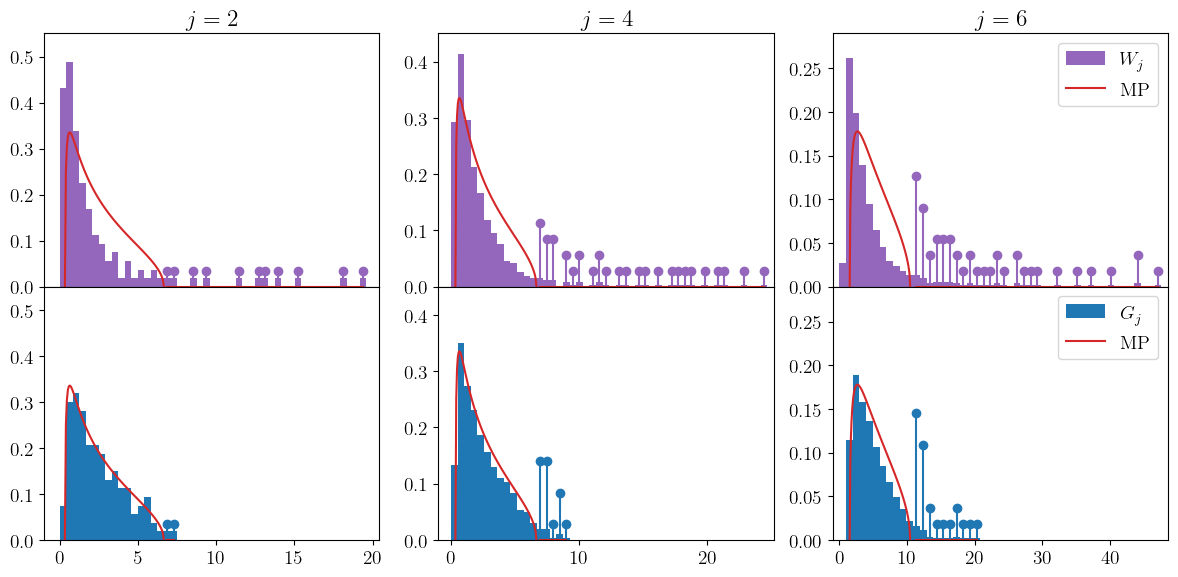

In [10]:
""" MP plots. """

js = [2, 4, 6]
spikes = True
when = "single"  #"MP"  # or firstzero
fig, axs = plt.subplots(figsize=(12, 6), ncols=len(js), nrows=2, 
                        sharex="col", gridspec_kw=dict(hspace=0))

def mp(x, q):
    """ Applies the MP probability density function on x. q is the ratio d/n. Assumes variance = 1. """
    q_p = (1 + np.sqrt(q)) ** 2
    q_m = (1 - np.sqrt(q)) ** 2
    i = (q_p - x) * (x - q_m)
    y = torch.sqrt(i) / (2 * np.pi * q * x)

    y[i < 0] = 0  # Takes care of NaNs from negative square roots and division by zero.
    if q > 1:
        y *= q  # Renormalizes to forget about the atom at zero.

    return y

for col, j in enumerate(js):    
    # Compute atoms of exp aligned with respect to ref.
    colored_atoms = aligned.aligned_weight(j=j, key=key)  # (N, D)
    n, d = colored_atoms.shape

    q = d / n
    q_p = (1 + np.sqrt(q)) ** 2
    q_m = (1 - np.sqrt(q)) ** 2
    t = torch.linspace(q_m, q_p, 100)
    i = (q_p - t) * (t - q_m)
    y = torch.sqrt(i) / (2 * np.pi * q * t)
    y[i < 0] = 0  # Takes care of NaNs from negative square roots and division by zero.
    if q > 1:
        y *= q  # Renormalizes to forget about the atom at zero.

    # Covariance used for whitening is either the one of ref_exp or the one averaged over many exps.
    cov = aligned.covariance(j=j)
    # Compute whitened atoms of exp.
    white_atoms = colored_atoms @ cov.rsqrt().matrix  # (N, D)
    
    colored_spectrum = empirical_covariance(colored_atoms).eigenvalues
    colored_spectrum /= colored_spectrum.sum() / d
    m = colored_spectrum[0].item() + 1
    
    for row, (name, atoms) in enumerate(dict(
        colored=colored_atoms, 
        white=white_atoms,
    ).items()):
        plt.sca(axs[row][col])
        
        spectrum = empirical_covariance(atoms).eigenvalues
        # Normalize
        spectrum /= spectrum.sum() / d
        
        num_outside = torch.mean(((spectrum < q_m) | (spectrum > q_p)).float())
        print(fr"{j=} {name} ({100 * num_outside.item():.1f}%)")
        label = dict(colored="$W_j$", white="$G_j$")[name]
        ymax = {1: 0.55, 2: 0.55, 4: 0.45, 6:0.29}[j]
        
        bins = np.linspace(0, m, 50)
        
        if spikes:
            counts_true, _ = np.histogram(spectrum.cpu().numpy(), bins=bins, density=False)
            counts, edges = np.histogram(spectrum.cpu().numpy(), bins=bins, density=True)

            if when == "firstzero":
                # Measure first zero after the bulk after the first non-zero
                threshold = {2: 1, 4: 1, 6: 1}[j]
                seen_nonzero = False
                for i, c in enumerate(counts_true):
                    if c < threshold:
                        if seen_nonzero:
                            break
                    else:
                        seen_nonzero = True
                first_zero = i

                # plot histogram for first part
                plt.stairs(counts[:first_zero], edges[:first_zero + 1],
                           color=dict(colored="tab:purple", white="tab:blue")[name],
                           label=label, fill=True)
                # Plot dirac masses for the rest
                threshold = edges[first_zero]
                x = spectrum[spectrum >= threshold].cpu().numpy()
                if len(x) > 0:
                    height = ymax / 4 * np.ones(len(x))
                    plt.stem(x, height, 
                             linefmt=dict(colored="tab:purple", white="tab:blue")[name],
                             markerfmt="o")
            elif when == "MP":
                plt.stairs(counts, edges,
                           color=dict(colored="tab:purple", white="tab:blue")[name],
                           label=label, fill=True)
                
                # Plot dirac masses for the rest
                threshold = q_p
                x = spectrum[spectrum >= threshold].cpu().numpy()
                if len(x) > 0:
                    height = ymax / 8 * np.ones(len(x))
                    plt.stem(x, height, 
                             linefmt=dict(colored="tab:purple", white="tab:blue")[name],
                             markerfmt="o")
            
            elif when == "single":
                plt.stairs(counts, edges,
                           color=dict(colored="tab:purple", white="tab:blue")[name],
                           label=label, fill=True)
                
                # Plot dirac masses on top of the bins
                threshold = q_p
                x = (edges[:-1] + edges[1:]) / 2
                I = (x >= threshold) & (counts > 0)
                x = x[I]
                if len(x) > 0:
                    height = ymax / 16 * np.ones(len(x)) * counts[I] / counts[I].min()
                    plt.stem(x, height, 
                             linefmt=dict(colored="tab:purple", white="tab:blue")[name],
                             markerfmt="o")
        else:
            plt.hist(spectrum.reshape((-1,)).cpu().numpy(), #bins=max(10, min(100, spectrum.shape[0] // 100)),
                     density=True, color=dict(colored="tab:purple", white="tab:blue")[name],
                     label=label, histtype=dict(colored="stepfilled", white="stepfilled")[name], 
                     alpha=dict(colored=1.0, white=1.0)[name], bins=bins, #zorder=dict(colored=1, white=0)[name]
                    )

        plt.plot(t.cpu().numpy(), y.cpu().numpy(), label="MP", color="tab:red")
        
        if row == 0:
            plt.title(f"$j = {j}$")
        if col == len(js) - 1:
            plt.legend()
        
        plt.xlim(-1, m)
        plt.ylim(0, ymax)
    #     plt.yscale("log")

plt.tight_layout()
savefig("marchenko_pastur")
plt.show()

## Resampling

{'trained': [88.0, 89.7, 91.1, 91.6, 91.9, 91.9], 'gaussian': [54.8, 67.2, 76.3, 81.4, 84.0, 84.7], 'orthogonal': [nan, nan, nan, nan, nan, nan]}


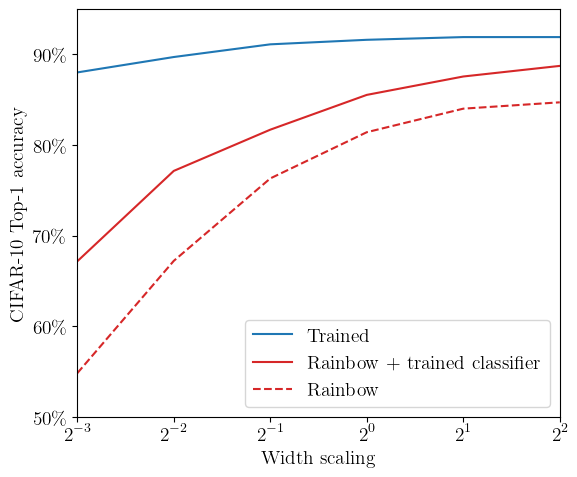

In [7]:
""" Resampling as a function of width. """

def parse_file(file):
    """ Returns model, metric, j -> perf. """
    results = {}
    j = 0
    with open(file, "r") as f:
        for line in f.readlines():
            line = line.rstrip()
            if line.startswith("j="):
                new_j = int(line[2:])
                # Note: more recent results will override older ones.
                j = new_j
            else:
                for metric in ["top1", "top5"]:
                    if line.endswith(metric):
                        words = line.split(": ")
                        model = words[0]
                        perf = float(words[1].split("%")[0])
                        results[model, metric, j] = perf
#     print(file, results)
    return results
    
def perf_data(dataset, models, j=None, **plot_kwargs):
    """ models is a list of (x, model, suffix) triplets.
    model is the experiment name to resample, and suffix an optional suffix in the resample file name.
    """
    if dataset == "cifar":
        if j is None:
            j = 7
        metric = "top1"
    elif dataset == "imagenet":
        if j is None:
            j = 10
        metric = "top5"
    
    xs = []
    labels = ["trained", "gaussian", "orthogonal"]
    lines = {label: [] for label in labels}
    for x, model, suffix in models:
        xs.append(x)
        file = f"resamplings/resample-{model}{suffix}"
        results = parse_file(file)
        for label in labels:
            model_name = model if label == "trained" else f"{model}-{label}-try0"
            try:
                result = results[model_name, metric, j]
            except KeyError:
                result = np.nan
            lines[label].append(result)
            
    return xs, lines
    
dataset = "cifar"
def model(w, skip=False):
    sizes = [int(w * s) for s in [64, 128, 256, 512, 512, 512, 512, 512]]
    arch = "".join(f"WP{s}" for s in sizes)
    return f"cifar-{arch}{'-skip' if skip else ''}-norm-L4-clbnstd-clnobias"

skip = True
max_scale = 2 if skip else 3
models = [(w, model(w, skip=skip), "") for w in [2 ** i for i in range(-3, max_scale + 1)]]
x, lines = perf_data(dataset, models)
print(lines)

lines["trainedclf"] = [67.15, 77.13, 81.68, 85.52, 87.55, 88.72]

plt.figure(figsize=(6, 5))
plt.plot(x, lines["trained"], color="tab:blue", label="Trained")
plt.plot(x, lines["trainedclf"], color="tab:red", label="Rainbow + trained classifier")
plt.plot(x, lines["gaussian"], color="tab:red", label="Rainbow", linestyle="--")
plt.xscale("log")
plt.xticks(ticks=x, labels=[f"$2^{{{i}}}$" for i in range(-3, max_scale + 1)], minor=False)
plt.xticks(ticks=[], labels=[], minor=True)
plt.xlim(x[0], x[-1])
plt.xlabel("Width scaling")
plt.ylabel(r"CIFAR-10 Top-1 accuracy")
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: rf'{x:.0f}\%'))
plt.ylim(50, 95)
plt.yticks(np.arange(50, 100, 10))
plt.legend()

plt.tight_layout()
savefig("resampling_width")
plt.show()

## Width scaling experiments - Activation convergence

Found 1 exps matching cifar-WP512WP1024WP2048WP4096WP4096WP4096WP4096WP4096-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP8WP16WP32WP64WP64WP64WP64WP64-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP16WP32WP64WP128WP128WP128WP128WP128-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP32WP64WP128WP256WP256WP256WP256WP256-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP64WP128WP256WP512WP512WP512WP512WP512-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP128WP256WP512WP1024WP1024WP1024WP1024WP1024-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP256WP512WP1024WP2048WP2048WP2048WP2048WP2048-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP512WP1024WP2048WP4096WP4096WP4096WP4096WP4096-norm-L4-clbnstd-clnobias


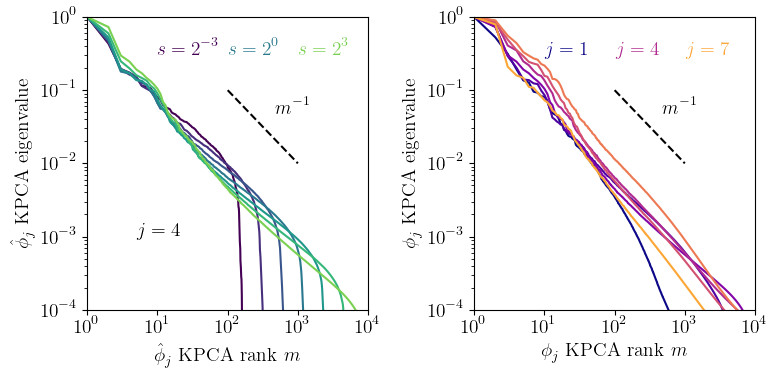

In [54]:
""" Sepctra of activations - for J8 models. """

from matplotlib import cm

extent = 0.8

for j in [4]:
    i_scalings = list(range(-3, 4))
    scalings = [2 ** i for i in i_scalings]

    # Could use bis experiments
    def pattern(w):
        sizes = [int(w * s) for s in [64, 128, 256, 512, 512, 512, 512, 512]]
        arch = "".join(f"WP{s}" for s in sizes)
        return f"cifar-{arch}-norm-L4-clbnstd-clnobias"

    ref_scaling = scalings[-1]
    ref_p = pattern(ref_scaling)
    ref_exp = exps.load_pattern(pattern=ref_p, log=False, single=True)
    # for j in ref_exp.js:
    #     ref_exp.activation_covariance_eigenvalues(j=j, batch_size=128)

    scaling_exps = {}
    for s in scalings:
        p = pattern(s)
        exps_dict = exps.load_pattern(pattern=p, log=False, num=1)
        scaling_exps[s] = AlignedExperiments(exps_dict, ref_exp=ref_exp)
    #     for j in scaling_exps[s].js:
    #         for i, exp in enumerate(exps_dict.values()):
    #             # Compute activation spectrum
    #             exp.activation_covariance_eigenvalues(j=j, batch_size=128)
    #             # Compute alignment error
    #             print(f"{s=} {j=} {i=}", exp.alignment_error(j=j, other_exp=ref_exp, test=True, batch_size=128))


    fig, axs = plt.subplots(figsize=(8, 4), ncols=2, width_ratios=[0.3, 0.3])
    epoch = None
    num_exps = 1

    # Spectra of activations for various sizes
    plt.sca(axs[0])
    colors = matplotlib.cm.get_cmap("viridis")(np.linspace(0, 0.8, len(scalings)))
    for i, s in enumerate(scalings):
    #     if i % 2 == 1:
    #         continue
        for k, exp in enumerate(list(scaling_exps[s].exps_dict.values())[:num_exps]):
            y = exp.activation_covariance_eigenvalues(j=j, epoch=epoch)
#             y = y / exp.dimension(j=j) * ref_exp.dimension(j=j) / ref_exp.activation_covariance_eigenvalues(j=j, epoch=epoch)[0]
            y = y / y[0]
            y = y.cpu().numpy()
            x = 1 + np.arange(len(y))
            plt.plot(x, y, label=None if k > 0 else f"$s = 2^{{{i - 3}}}$", color=colors[i])
    # plt.legend(ncol=2)
    # c = plt.colorbar(cm.ScalarMappable(cmap="viridis"), ax=axs[0], location="right")
    # c.set_label("Width scaling $s$")
    # c.set_ticks(ticks=np.linspace(0, 1, len(scalings))[::2], labels=[f"$2^{{{i}}}$" for i in range(-3, 6, 2)])
    x = 10 ** np.linspace(2, 3, 3)
    y = 1e-1 * (x / x[0]) ** (-1)
    plt.plot(x, y, ls="--", color="black")
    plt.text(1.5 * x[1], 1.5 * y[1], " $m^{-1}$")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("$\hat\phi_j$ KPCA rank $m$")
    plt.ylabel(fr"$\hat\phi_j$ KPCA eigenvalue")
    plt.xlim(1e0, 1e4)
    plt.xticks([10 ** i for i in range(5)])
    plt.ylim(1e-4, 1e0)
    for i in [0, 3, 6]:
        plt.text({0: 1e1, 3: 1e2, 6: 1e3}[i], 3e-1, f"$s = 2^{{{i_scalings[i]}}}$", color=colors[i])
    plt.text(5e0, 1e-3, f"$j = {j}$", color="black")

    # Spectra of activations of reference network for all layers
    plt.sca(axs[1])
    js = [2, 3, 4, 5, 6, 7, 8]
    colors = matplotlib.cm.get_cmap("plasma")(np.linspace(0, extent, len(js)))
    for i, j in enumerate(js):
        y = ref_exp.activation_covariance_eigenvalues(j=j, epoch=epoch)
        y = y / y[0]
        y = y.cpu().numpy()
        x = 1 + np.arange(len(y))
    #     predict, exponent, coefficient = fit_affine(x=x, y=y, idx=slice(10, 100 if j == 2 else 1000),
    #                                                 x_log=True, y_log=True)    
        exponent = 0
        plt.plot(x, y, label=fr"$j = {j-1}$ ($\alpha = {-exponent:.2f}$)", color=colors[i])
    #     plt.plot(x, predict, color=colors[i], linestyle="--")
    # plt.legend()
    x = 10 ** np.linspace(2, 3, 3)
    y = 1e-1 * (x / x[0]) ** (-1)
    plt.plot(x, y, ls="--", color="black")
    plt.text(1.5 * x[1], 1.5 * y[1], " $m^{-1}$")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("$\phi_j$ KPCA rank $m$")
    plt.ylabel(r"$\phi_j$ KPCA eigenvalue")
    plt.xlim(1e0, 1e4)
    plt.xticks([10 ** i for i in range(5)])
    plt.ylim(1e-4, 1e0)
    for i in [0, 3, 6]:
        plt.text({0: 1e1, 3: 1e2, 6: 1e3}[i], 3e-1, f"$j = {i + 1}$", color=colors[i])
    
#     from matplotlib.colors import Normalize
#     c = plt.colorbar(cm.ScalarMappable(cmap="plasma", norm=Normalize(vmin=0, vmax=1/0.8)),
#                      ax=plt.gca(), location="right", ticks=[0, 1/0.8])
#     c.ax.set_yticklabels(["First", "Last"])
#     c.ax.set_ylabel("Layer $j$", labelpad=-20)

    # plt.subplots_adjust(wspace=.1)
    plt.tight_layout()
    savefig("alignment_convergence_all_layers_J8_spectra")
    plt.show()

## ResNet activation convergence

Found 1 exps matching cifar-WP512WP1024WP2048WP4096WP4096WP4096WP4096WP4096-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP8WP16WP32WP64WP64WP64WP64WP64-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP16WP32WP64WP128WP128WP128WP128WP128-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP32WP64WP128WP256WP256WP256WP256WP256-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP64WP128WP256WP512WP512WP512WP512WP512-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP128WP256WP512WP1024WP1024WP1024WP1024WP1024-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP256WP512WP1024WP2048WP2048WP2048WP2048WP2048-norm-L4-clbnstd-clnobias
Found 1 exps matching cifar-WP512WP1024WP2048WP4096WP4096WP4096WP4096WP4096-norm-L4-clbnstd-clnobias
Found 1 exps matching standard-resnet18-nobias-clnobias-bnpost-widthX8-fix
Found 1 exps matching standard-resnet18-nobias-clnobias-bnpost-widthX0.125-fix
Found 1 exps matching standard-resnet18-nobias-clnobias-bnpost-widthX0.25-fix
Found 

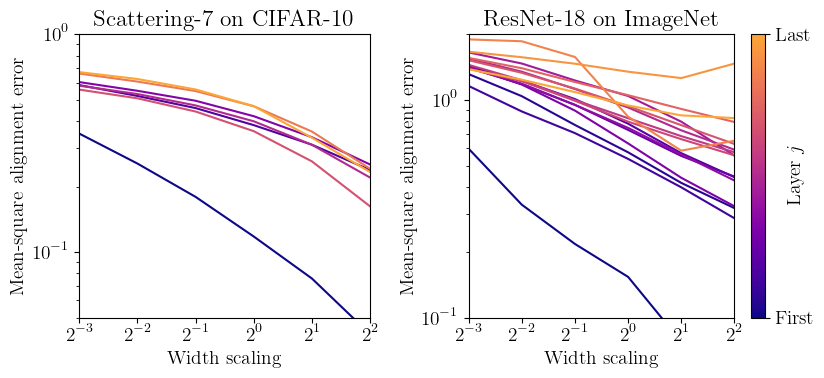

In [52]:
""" Convergence of activations - both scattering and ResNet. """

# Figure.

fig, axs = plt.subplots(figsize=(8.5, 4), ncols=2, width_ratios=[0.35, 0.4])
num_exps = 1

extent = 0.8

# js = range(1, 22)
# jj = [j for j in js[:-1] if j not in [7, 12, 17]]
# colors = matplotlib.cm.get_cmap("plasma")(np.linspace(0, 1.0, len(jj)))

# Scattering

i_scalings = list(range(-3, 4))
scalings = [2 ** i for i in i_scalings]
epoch = None

# Could use bis experiments
def pattern(w):
    sizes = [int(w * s) for s in [64, 128, 256, 512, 512, 512, 512, 512]]
    arch = "".join(f"WP{s}" for s in sizes)
    return f"cifar-{arch}-norm-L4-clbnstd-clnobias"

ref_scaling = scalings[-1]
ref_p = pattern(ref_scaling)
ref_exp = exps.load_pattern(pattern=ref_p, log=False, single=True)

scaling_exps = {}
for s in scalings:
    p = pattern(s)
    exps_dict = exps.load_pattern(pattern=p, log=False, num=1)
    scaling_exps[s] = AlignedExperiments(exps_dict, ref_exp=ref_exp)

plt.sca(axs[0])
js = [2, 3, 4, 5, 6, 7, 8]
colors = matplotlib.cm.get_cmap("plasma")(np.linspace(0, extent, len(js)))
for i, j in enumerate(js):
    x = scalings[:-1]
    scaling_aligned = list(scaling_exps.values())[:-1]

    errors = torch.stack(
        [torch.stack(
            [exp.alignment_error(j=j, other_exp=ref_exp, test=True, epoch=epoch, other_epoch=epoch)
             for exp in list(aligned.exps_dict.values())[:num_exps]],
            dim=0) for aligned in scaling_aligned],
        dim=0).cpu().numpy()  # (num_scalings, num_exps)
    errors_mean = errors.mean(1)  # (num_scalings,)
    errors_std = 3 * errors.std(1)  # (num_scalings,)
#     predict, exponent, coefficient = fit_affine(x=x, y=errors_mean, x_log=True, y_log=True)
    exponent = 0
    plt.plot(x, errors_mean, color=colors[i], label=fr"$j = {j- 1}$ ($\eta = {-exponent:.2f}$)")
#     plt.fill_between(x, errors_mean - errors_std, errors_mean + errors_std, color=colors[i], alpha=0.5)
#     plt.plot(x, predict, color=colors[i], linestyle="--")
# plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Width scaling")
#     plt.ylabel(r"$\mathbb E_x [ \| \hat A_j \hat \phi_j(x) - \phi_j(x) \|^2 ] / \mathbb E_x [ \| \phi_j(x) \|^2 ]$")
plt.ylabel(r"Mean-square alignment error")
plt.xticks(ticks=x, labels=[f"$2^{{{i}}}$" for i in i_scalings[:-1]], minor=False)
plt.xticks(ticks=[], labels=[], minor=True)
plt.xlim(x[0], x[-1])
plt.ylim(5e-2, 1e0)
# plt.ylim(1e-1, 2e0)
plt.title("Scattering-7 on CIFAR-10")

#     for i in [0, 3, 6]:
#         plt.text({0: 2**-1.5, 3: 2**-0.5, 6: 2**0.5}[i], 7e-1, f"$j = {i + 1}$", color=colors[i])
# plt.text(2**-2, 1.5e-1, f"$j = 1$", color=colors[0])
# plt.text(2**-1, 3e-1, f"$j = 4$", color=colors[3])
# plt.text(2**-0, 5e-1, f"$j = 7$", color=colors[6])




# ResNet

scalings = [2 ** i for i in range(-3, 4)]

def pattern(w):
    return f"standard-resnet18-nobias-clnobias-bnpost-widthX{w}-fix"

ref_scaling = scalings[-1]
ref_p = pattern(ref_scaling)
ref_exp = exps.load_pattern(pattern=ref_p, log=False, single=True)
# for j in ref_exp.js:
#     ref_exp.activation_covariance_eigenvalues(j=j, batch_size=128)
    
scaling_exps = {}
for s in scalings:
    p = pattern(s)
    exps_dict = exps.load_pattern(pattern=p, log=False, num=1)
    scaling_exps[s] = AlignedExperiments(exps_dict, ref_exp=ref_exp)
    js = scaling_exps[s].js


epoch = None
standardize = True
plt.sca(axs[1])
jj = [j for j in js[:-1] if j not in [7, 12, 17]]
colors = matplotlib.cm.get_cmap("plasma")(np.linspace(0, extent, len(jj)))

x = scalings[:-1]
scaling_aligned = [scaling_exps[s] for s in x]
errors = {j: [] for j in js}
for aligned in scaling_aligned:
    exp = aligned.exp
    errors_exp = exp.alignment_error(j=js, other_exp=ref_exp, test=True, standardize=standardize,
                                     epoch=epoch, other_epoch=epoch)  # j, "aa",etc -> error
#     print(errors_exp)
    for j in js:
        if quantity == "error":
            error = 2 * (1 - errors_exp[j, "ab"] / torch.sqrt(errors_exp[j, "aa"] * errors_exp[j, "bb"]))
#                 error = errors_exp[j, "aa"] + errors_exp[j, "bb"] - 2 * errors_exp[j, "ab"]
        elif quantity == "variance":
            error = errors_exp[j, "aa"] #/ (errors[j][0] if len(errors[j]) > 0 else errors_exp[j, "aa"])
        errors[j].append(error)
errors_mean = {j: torch.stack(e) for j, e in errors.items()}

for i, j in enumerate(jj):
    plt.plot(x, errors_mean[j + 1].cpu().numpy(), color=colors[i])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Width scaling")
plt.ylabel(r"Mean-square alignment error")
plt.ylim(1e-1, 2e0)
plt.xticks(ticks=x, labels=[f"$2^{{{i}}}$" for i in range(-3, -3 + len(x))], minor=False)
plt.xticks(ticks=[], labels=[], minor=True)
plt.xlim(x[0], x[-1])
plt.title("ResNet-18 on ImageNet")

colors = matplotlib.cm.get_cmap("plasma")(np.linspace(0, extent, 256))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
c = plt.colorbar(cm.ScalarMappable(cmap=cmap),
                 ax=plt.gca(), location="right", ticks=[0, 1])
c.ax.set_yticklabels(["First", "Last"])
c.ax.set_ylabel("Layer $j$", labelpad=-20)

# plt.subplots_adjust(wspace=.1)
plt.tight_layout()
savefig(f"alignment_convergence_scattering_resnet")
plt.show()

## Convergence of covariance

In [10]:
""" Build old experiments sets. """


# Scalings are s = 2**i with i=-3, .., 6 included
# i=6 is too big, we choose i=5 as ref.
scalings = [2 ** i for i in range(-3, 6)]

ref_scaling = scalings[-1]
ref_p = exp_pattern(s=ref_scaling, name="scalewidth") + "09"
ref_exp = exps.load_pattern(pattern=ref_p, log=False, single=True)
for j in [2, 3, 4]:
    ref_exp.activation_covariance_eigenvalues(j=j, batch_size=128)
    
scaling_exps = {}
for s in scalings:
    p = exp_pattern(s=s, name="scalewidth")
    exps_dict = exps.load_pattern(pattern=p, log=False, num=10)
    scaling_exps[s] = AlignedExperiments(exps_dict, ref_exp=ref_exp)
#     for j in [2, 3, 4]:
#         for i, exp in enumerate(exps_dict.values()):
#             # Compute activation spectrum
#             exp.activation_covariance_eigenvalues(j=j, batch_size=128, recompute=i >= 1 and (s, j, i) > (32, 3, 9))
#             # Compute alignment error
#             print(f"{s=} {j=} {i=}", exp.alignment_error(j=j, other_exp=ref_exp, test=True, batch_size=128,


js = [2]
scaling_exps_sets = {}  # scaling_axis -> scaling_name -> AlignedExperiment

for scaling_axis in ['M']:
    
    def change_sizes(sizes, js, s):
        return [int(size * s) if j in js else size for j, size in enumerate(sizes, start=1)]
    def arch(sizes, std=True):
        return "W" + "W".join(f"P{size}" if size != "id" else "" for size in sizes) + ("-L4" if std else "-nostd")
    def pattern(sizes=[64, 128, 256, 512], js=[], s=1, std=True):
        return f"cifar-{arch(change_sizes(sizes, js, s), std=std)}-clbnstd-clnobias-nowd-paperexps-init"

    for std in [True]:
        scalings_dict = {}
        
        if scaling_axis == "M":
            p = pattern(std=std)
            for M in [1, 10, 50][::-1]:
                exps_dict = exps.load_pattern(p, log=False, full_names=True, num=M)
                aligned = AlignedExperiments(exps_dict, js=js, recompute=False, batch_size=64)
                scalings_dict[f"$M = {M}$"] = aligned
        else:
            for s in [1, 2, 4]:
                p = pattern(js=[dict(N=2, D=1)[scaling_axis]], s=s, std=std)
                exps_dict = exps.load_pattern(p, log=False, full_names=True, num=50)
                aligned = AlignedExperiments(exps_dict, js=js, recompute=False, batch_size=64)
                scalings_dict[f"${scaling_axis} = {dict(N=128, D=320)[scaling_axis] * s}$"] = aligned
        
        scaling_exps_sets[scaling_axis] = scalings_dict
        
ref_aligned = scaling_exps[ref_scaling]

Found 1 exps matching cifar-WP2048WP4096WP8192WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init09
Found 10 exps matching cifar-WP8WP16WP32WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP16WP32WP64WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP32WP64WP128WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP64WP128WP256WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP128WP256WP512WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP256WP512WP1024WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP512WP1024WP2048WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP1024WP2048WP4096WP512-L4-clbnstd-clnobias-nowd-paperexps-scalewidth-init
Found 10 exps matching cifar-WP2048WP4096WP8192WP512-L4-clbnstd-clnobias-nowd-paperexps-sca

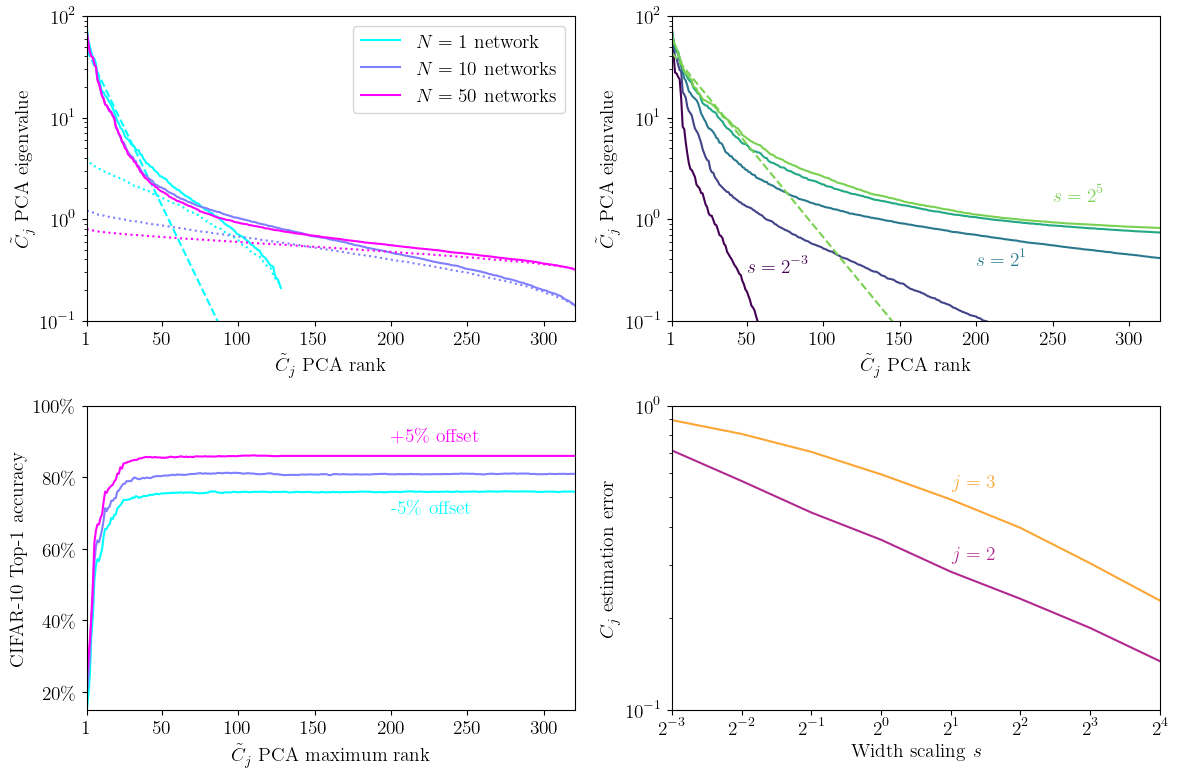

In [11]:
""" Convergence of weights - the complete figure. """

from notebook.linalg import fit_affine
from matplotlib import cm
m_colors = list(matplotlib.cm.get_cmap("cool")(np.linspace(0, 1.0, 3)))
nd_colors = list(matplotlib.cm.get_cmap("viridis")(np.linspace(0, 0.8, len(scalings))))
j_colors = matplotlib.cm.get_cmap("plasma")(np.linspace(0, 0.8, 3))

fit = None


fig, axs = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)

# Spectra of covariance and averaging
plt.sca(axs[0][0])
j = 2
scalings_dict = scaling_exps_sets["M"]
lw = 1.5
for i, (name, aligned) in enumerate(reversed(scalings_dict.items())):
    j = 2
    M = aligned.num_exps
    N = aligned.exp.num_atoms(j=j)
    D = aligned.exp.dimension(j=j)

    eigenvalues_final = aligned.covariance(j=j, epoch=None).eigenvalues * aligned.exp.dimension(j=j)  # (R,)
    eigenvalues_init = aligned.covariance(j=j, epoch=0).eigenvalues  # (R,)
    # Renormalize to make the tail align
    eigenvalues_init = eigenvalues_init * eigenvalues_final[-1] / eigenvalues_init[-1]

    # Estimate exponentials parameters
    fit, _, _ = fit_affine(eigenvalues_final, idx=slice(0, 40), y_log=True)
    x = 1 + np.arange(len(eigenvalues_final))
    color = m_colors[i]
    if i == 0:
        plt.plot(x, fit.cpu().numpy(), color=color, linewidth=1.5, linestyle="--")
    for epoch in [0, None]:
        eigenvalues = {0: eigenvalues_init, None: eigenvalues_final}[epoch]
        linestyle = {0: ":", None: "-"}[epoch]
        linewidth = lw if i == 0 and epoch is None else 1.5
        label = {0: None, None: f"$N = {M}$ network{'s' if M > 1 else ''}"}[epoch]
        plt.plot(x, eigenvalues.cpu().numpy(), color=color, linewidth=linewidth, 
                 linestyle=linestyle, label=label)
    plt.ylim(1e-1, 1e2)
    plt.xlim(1, 320)
    plt.xticks([1, 50, 100, 150, 200, 250, 300])
    plt.yscale("log")
    plt.ylabel(rf"$\tilde C_j$ PCA eigenvalue")
    plt.xlabel(r"$\tilde C_j$ PCA rank")
    plt.legend()

    
    
# Spectra of covariance for various sizes
plt.sca(axs[0][1])
j = 2
scaling_slice = slice(None, None, 2)
true_scalings = scalings[scaling_slice]
xlim = 30
for i, (s, aligned) in enumerate(scaling_exps.items()):
    if s not in true_scalings:
        continue
    y = aligned.covariance_eigenvalues(j=j, epoch=epoch, align_epoch=epoch, 
                                       log=False) * aligned.exp.dimension(j=j)
#         y = y / y[0]
    y = y.cpu().numpy()
    x = 1 + np.arange(len(y))
    plt.plot(x, y, label=f"Width scaling $s = 2^{{{i - 3}}}$", color=nd_colors[i])
    if s == true_scalings[-1]:
        predict, scale, coefficient = fit_affine(y, y_log=True, idx=slice(0, 50))
        plt.plot(x, predict, color=nd_colors[i], linestyle="--")
    
# plt.legend()
i_scalings = list(range(-3, 6))
for i in [0, 4, 8]:
    plt.text({0: 50, 4: 200, 8: 250}[i], {0: 3e-1, 4: 3.5e-1, 8: 1.5e0}[i],
             f"$s = 2^{{{i_scalings[i]}}}$", color=nd_colors[i])
# c = plt.colorbar(cm.ScalarMappable(cmap="viridis"), ax=plt.gca(), location="right")
# c.set_label("Width scaling $s$")
# c.set_ticks(ticks=np.linspace(0, 1, len(scalings))[scaling_slice],
#             labels=[f"$2^{{{i}}}$" for i in list(range(-3, 6))[scaling_slice]])
plt.yscale("log")
plt.xlabel(r"$\tilde C_j$ PCA rank")
plt.ylabel(fr"$\tilde C_j$ PCA eigenvalue")
plt.xlim(1, 320)
plt.xticks([1, 50, 100, 150, 200, 250, 300])
plt.ylim(1e-1, 1e2)
# plt.xscale("log")



# Clipping
ax = axs[1][0]
plt.sca(ax)
j = 2
dj = 320
ds = np.arange(0, dj + 1).astype(int)
num_inits = 1
clip_perfs = torch.load("notebook_data/cifar_clipping_m")
m_aligned_exps = {name: (aligned, None) for name, aligned in scaling_exps_sets["M"].items()}
perfs = {name: [clip_perfs[f"{name} clip{d}", "top1"] for d in ds] for name in m_aligned_exps.keys()}
for i, (name, clip_res) in enumerate(perfs.items()):
    offset = 5 * i -5
    ax.plot(ds, [c.item() + offset for c in clip_res], zorder=i, label=f"Init {i + 1}", color=m_colors[i],
           )
plt.text(200, 90, "+5\% offset", color=m_colors[2])
plt.text(200, 70, "-5\% offset", color=m_colors[0])
ax.set_ylabel(r"CIFAR-10 Top-1 accuracy")
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: rf'{x:.0f}\%'))
ax.set_ylim(15, 100)
#             ax.set_xticks([1] + list(range(0, dj, 20))[1:])
#             ax.set_xlim(0, 129)
#                 ax.legend(loc="lower right")
plt.xlabel(r"$\tilde C_j$ PCA maximum rank")
plt.xlim(1, dj)
plt.xticks([1, 50, 100, 150, 200, 250, 300])


# Covariance convergence
plt.sca(axs[1][1])
p = "inf"
js = [1, 2, 3]
for i, j in enumerate(js):
    if j == 1:
        continue
    y = []
    for k, (s, aligned) in enumerate(list(scaling_exps.items())[:-1]):
        # Compute norm of ref covariance to have meaningful y axis
        if j >= 1:
            assert p == "inf"
            n = ref_aligned.covariance_eigenvalues(j=j, cuda=True)[0] * ref_aligned.exp.dimension(j=j)
        else:
            n = aligned.covariance_eigenvalues(j=j, cuda=True)[0] * ref_aligned.exp.dimension(j=j)
        y.append(aligned.covariance_error(j=j, ref_aligned=ref_aligned, p=p, renorm=False, log=False) / n)
    y = torch.stack(y).cpu().numpy()
    x = scalings[:-1]
    predict, exponent, coefficient = fit_affine(x=x, y=y, x_log=True, y_log=True, idx=slice(3, 8))
    plt.plot(x, y, color=j_colors[i], linestyle="-", label=f"$j = {j}$ ($\eta = {-exponent:.2f}$)")
    plt.text(x[len(x) // 2], y[len(x) // 2] * 1.1, f"$j = {j}$", color=j_colors[i])
#     plt.plot(x, predict, color=j_colors[i], linestyle="--")
    
# plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Width scaling $s$")
# plt.ylabel(r"$\| \tilde C_j - C_j \|_\infty / \|C_j \|_\infty $")
plt.ylabel(r"$C_j$ estimation error")
plt.xlim(2 ** -3, 2 ** 4)
plt.xticks(ticks=x, labels=[f"$2^{{{i}}}$" for i in range(-3, 5)], minor=False)
plt.xticks(ticks=[], labels=[], minor=True)
plt.ylim(1e-1, 1e0)
plt.yticks(ticks=[1e-1 * i for i in range(1, 10)], labels=[""] * 9, minor=True)


# plt.subplots_adjust(wspace=.1)
plt.tight_layout()
savefig("covariance_convergence")
plt.show()

## ImageNet, ResNet

2 3 tensor([1.0000, 0.1746, 0.1248, 0.1114, 0.1021, 0.0873, 0.0790, 0.0705, 0.0657,
        0.0630], device='cuda:0')
3 4 tensor([2.3714, 0.4725, 0.2942, 0.2672, 0.2570, 0.2254, 0.2118, 0.2108, 0.1929,
        0.1796], device='cuda:0')
4 5 tensor([5.6234, 1.3266, 0.9226, 0.7342, 0.6231, 0.5954, 0.5412, 0.4926, 0.4556,
        0.4198], device='cuda:0')
5 6 tensor([13.3352,  3.0859,  2.0657,  1.6884,  1.4900,  1.2036,  1.1941,  1.0428,
         1.0054,  0.9430], device='cuda:0')
6 7 tensor([31.6228,  7.9066,  7.5062,  4.7862,  3.3895,  3.2228,  3.1131,  2.9805,
         2.7238,  2.3955], device='cuda:0')
7 8 tensor([74.9894, 21.8873, 20.0569, 10.1116,  8.8826,  8.4031,  8.2201,  7.8840,
         7.3310,  7.0204], device='cuda:0')
8 9 tensor([177.8279,  60.2234,  46.4794,  25.1710,  23.1952,  21.4842,  20.7345,
         20.3209,  19.9275,  18.7660], device='cuda:0')
9 10 tensor([421.6965,  92.1735,  72.2380,  66.4390,  60.3784,  48.5488,  44.7967,
         41.1325,  38.1557,  37.1906], de

/tmp/ipykernel_2172284/3273267784.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


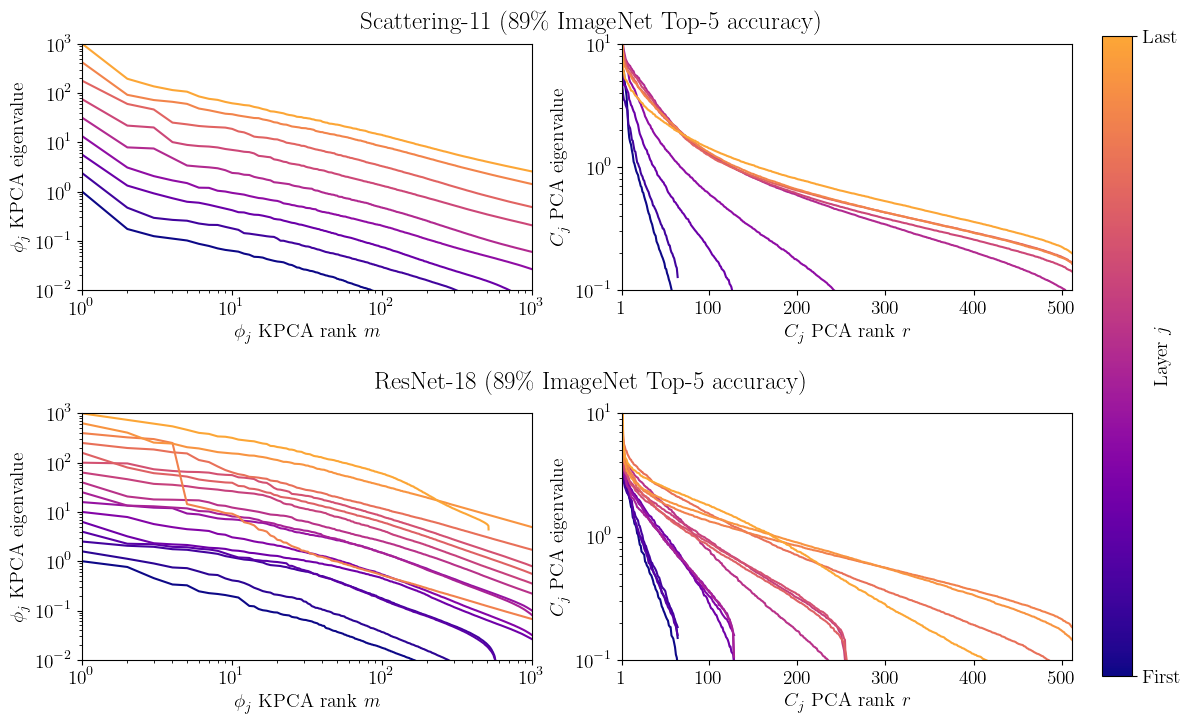

In [56]:
extent = 0.8

imagenet_J11 = "imagenet-iclr-L4-skip-Pc-nonorm"
covs_imagenet = torch.load("notebook_data/covs_imagenet_big")
add = {}
for key, v in covs_imagenet.items():
    add[key + ("input",)] = v
covs_imagenet.update(add)
resnet18 = "standard-resnet18-nobias-clnobias-bnpost"
covs_resnet = torch.load("notebook_data/covs_resnet_new_patches")
add = {}
for key, v in covs_resnet.items():
    add[key + ("input",)] = v
covs_resnet.update(add)

# NOTE: pre/post refer to L_j, not non-linearity...
spectra = ["pre-activations", "weights", 
                 #"post-activations",
                ]
networks = ["scattering", "resnet"]
fig, axs = plt.subplots(figsize=(12, 8), nrows=len(networks), ncols=len(spectra),
                        gridspec_kw=dict(hspace=0.5),
#                         sharex="col", sharey="col",
                       )

for col, spectrum in enumerate(spectra):
    for row, network in enumerate(networks):
        plt.sca(axs[row][col])
        
        if network == "scattering":
            jj = [j for j in list(range(1, 12)) if j not in [1, 11]]
            covs = covs_imagenet
            pattern = imagenet_J11
        elif network == "resnet":
            jj = [j for j in list(range(1, 21)) if j not in [1, 8, 13, 18]]
            covs = covs_resnet
            pattern = resnet18
        
        if spectrum == "weights":
            log = False
            exps_dict = exps.load_pattern(pattern, log=log, full_names=True, num=1)
            aligned = AlignedExperiments(exps_dict, recompute=False, batch_size=1024, num_iters=-1, log=log)
            
        colors = list(matplotlib.cm.get_cmap("plasma")(np.linspace(0, extent, len(jj))))
            
        for i, j in enumerate(jj):
            if spectrum == "weights":
                covariance_p = aligned.covariance(j=j, epoch=None)
                sp = covariance_p.eigenvalues  # (R,)
                sp /= sp.mean()
#                 sp = sp / sp[0]
                x = 1 + np.arange(len(sp))
                plt.plot(x, sp.cpu().numpy(), color=colors[i])
            elif "activations" in spectrum:
                act = {"pre-activations": "input", "post-activations": "output"}[spectrum]
                next_j = jj[i + 1] if i + 1 < len(jj) else j + 1
#                 if next_j != j + 1:
#                     continue
                sp = covs["", "", next_j, act].eigenvalues
#                 sp /= sp.mean()
                sp = sp / sp[0] * 10 ** (3 * i / (len(jj) - 1))
                print(j, next_j, sp[:10])
                x = 1 + np.arange(len(sp))
                plt.plot(x, sp.cpu().numpy(), color=colors[i],
                         linestyle="-")
    
        if spectrum == "weights":
            plt.ylim(1e-1, 1e1)
            plt.ylabel("$C_j$ PCA eigenvalue")
            plt.xlabel("$C_j$ PCA rank $r$")
            plt.xticks([1, 100, 200, 300, 400, 500])
            plt.xlim(1, 512)
        elif spectrum == "pre-activations":
            plt.ylim(1e-2, 1e3)
            plt.ylabel("$\phi_j$ KPCA eigenvalue")
            plt.xscale("log")
            plt.xlabel("$\phi_j$ KPCA rank $m$")
            plt.xlim(1, 1e3)
            
#             x = 10 ** np.linspace(2, np.log10(2e2), 3)
#             y = 2.5e2 * (x / x[0]) ** (-1)
#             plt.plot(x, y, ls="--", color="black")
#             plt.text(1.5 * x[1], 1.5 * y[1], " $m^{-1}$")
        plt.yscale("log")

plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.09, 0.025, 0.8])
colors = matplotlib.cm.get_cmap("plasma")(np.linspace(0, extent, 256))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), cax=cbar_ax, ticks=[0, 1])
cbar.ax.set_yticklabels(["First", "Last"])
cbar.ax.set_ylabel("Layer $j$", labelpad=-20)

for network in ["scattering", "resnet"]:
    title = dict(
#                 scattering="Scattering network",
        scattering="Scattering-11 (89\% ImageNet Top-5 accuracy)",
#                 resnet="ResNet-18",
        resnet="ResNet-18 (89\% ImageNet Top-5 accuracy)",
    )[network]
    plt.text(s=title, x=0.55, y=dict(scattering=0.90, resnet=0.45)[network], 
             ha="center", transform=fig.transFigure, fontsize=18)

savefig("scattering_resnet_new_patches")
plt.show()

## Weight vs Activation PCA

In [90]:
""" True KPCA vs Cov PCA figure - J8. """


merge_std = False
M = 50

def model(w):
    sizes = [int(w * s) for s in [64, 128, 256, 512, 512, 512, 512, 512]]
    arch = "".join(f"WP{s}" for s in sizes)
    return f"cifar-{arch}-norm-L4-clbnstd-clnobias"
pattern = model(1) + "-gaussiantest-init"
exps_dict = exps.load_pattern(pattern, log=False, full_names=True, num=M)
aligned = AlignedExperiments(exps_dict, merge_std=merge_std)

Found 50 exps matching cifar-WP64WP128WP256WP512WP512WP512WP512WP512-norm-L4-clbnstd-clnobias-gaussiantest-init


In [ ]:
""" Compute clipping in three bases. """

def clip(aligned_exps: Dict[Any, AlignedExperiments], js, clips: Dict[Any, Tuple[Any, str]],
         batch_size=1024, merge_std=False): 
    """ Clip a given network or ensemble of networks.
    :param aligned_exps: dictionary of align_key -> (AlignedExperiments, epoch), used for the possible alignment
    :param js: list of layers to clip
    :param clips: dictionary of clip_key -> (align_key, clip_dimensions)
    - align_key is the reference network to use (plus eventual realignment)
    - clip_projector is an orthogonal projector to use (D, D) (in space of mean/first experiment)
    :return: all_models, results
    - all_models is a dictionary of align_key -> clipped model
    - results is a dictionary of align_key, "top{k}" -> accuracy
    """
    all_exps = {}  # all experiments (reference models) used across all clippings
    # This relies on using full names for experiments, so that duplicates can be identified.
    for aligned_name, (exps, epoch) in aligned_exps.items():
        all_exps[aligned_name] = (exps.exp, epoch)

    exp = list(all_exps.values())[0][0]
    dataloader = exp.train_dataloader(batch_size)
    shapes = exp.linear_spatial_shapes
    
    # All models that we need to compute for comparing performance (will be populated with new models as well).
    all_models = {key: exp.model(epoch=epoch, cuda=True, merge_std=merge_std) for key, (exp, epoch) in all_exps.items()}
    # Placeholder state dicts for the new models.
    state_dicts = {clip_key: aligned_exps[aligned_key][0].exp.model(epoch=None, cuda=True, merge_std=merge_std).state_dict().copy()
                   for clip_key, (aligned_key, _) in clips.items()}
    alignments = {}  # clip_key -> alignment matrix (D_mean, D_resample)
    
    for i, j in enumerate(js):
        # First build intermediate models, with a clipped p_j but p_j+1 not aligned yet.
        
        for clip_key, (aligned_key, projector) in clips.items():
            exps = aligned_exps[aligned_key][0]
            exp = exps.exp
            
            n = exp.num_atoms(j=j)  # We could imagine specifying new widths
            d = exp.dimension(j=j)
            
            old_p = state_dicts[clip_key][exp.p_param_name(j=j)][:, :, 0, 0]  # (N, D)
            new_p = old_p @ projector  # (N, D)
            
            state_dicts[clip_key][exp.p_param_name(j=j)] = new_p[:, :, None, None]
            all_models[clip_key] = exp.model_with_state(state_dict=state_dicts[clip_key])

        # Evaluate models.
        
        for dataloader in exp.dataloaders(batch_size)[1:]:
            results = evaluate(all_models, dataloader)
            print(f"j={j}")
            for (model, metric), acc in results.items():
                if metric == "top1":
                    print(f"{model}: {acc.item():.1f}%")

    return all_models, results

js = [4, 6]
for j in js:
    d = aligned.exp.dimension(j=j)
    ds = np.arange(0, d + 1, d / 50).astype(int)

    clips = {}
    weight_cov = aligned.covariance(j=j)
    data_cov = aligned.data_covariance(j=j)
    gaussian = random_gaussian(weight_cov.matrix.shape,
                               dtype=weight_cov.matrix.dtype, device=weight_cov.matrix.device)
    random_cov = empirical_covariance(gaussian)
    for basis, matrix in dict(
        pca=weight_cov,
        kpca=data_cov,
        random=random_cov,
    ).items():
        for d in ds:
            proj = matrix.project(d).orthogonalize().matrix
            clips[f"clip{d}-{basis}"] = ("", proj)

    clip_models, clip_perfs = clip(aligned_exps={"": (aligned, None)}, js=[j], clips=clips)
    torch.save(clip_perfs, f"notebook_data/cifar_clipping_J8_j{j}.pt")

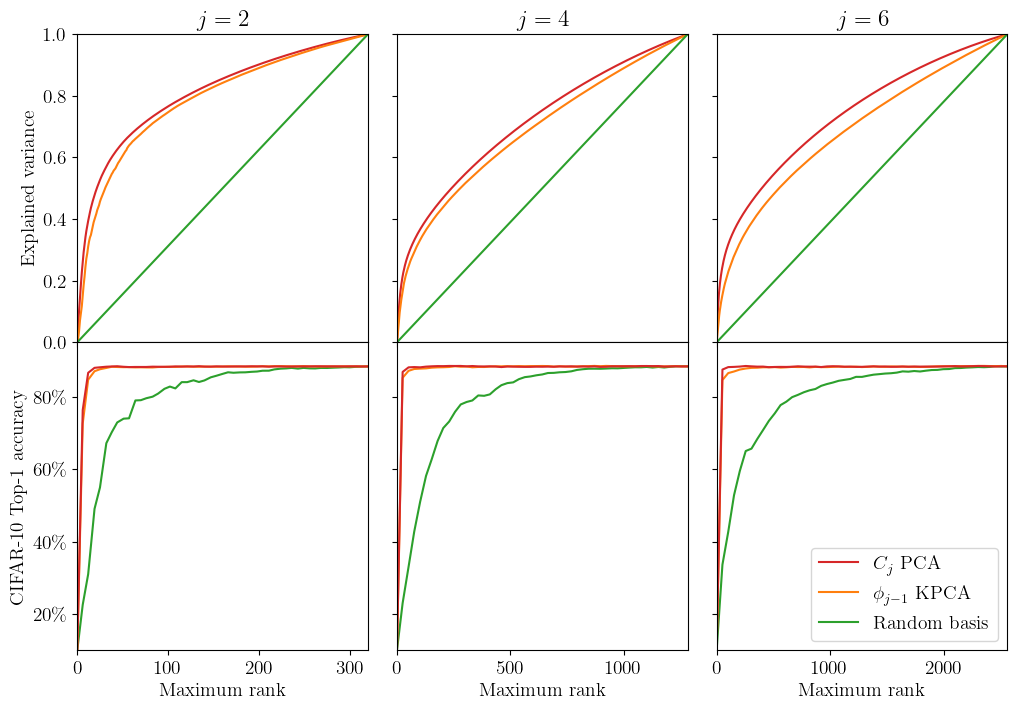

In [91]:
js = [2, 4, 6]

fig, axs = plt.subplots(nrows=2, ncols=len(js), figsize=(12, 8), sharey='row', sharex='col',
                        gridspec_kw=dict(hspace=0, wspace=0.1))
for col, j in enumerate(js):
    cov_w = aligned.covariance(j=j)  # (D, D)
    cov_z = aligned.data_covariance(j=j)  # (D, D)
    cov_w_z_basis = cov_z.eigenvectors @ cov_w.matrix @ cov_z.eigenvectors.T  # (D, D)

    diag_channel = cov_w.matrix.diag()
    diag_channel_sorted, _ = torch.sort(diag_channel, descending=True)
    diag_w_pca = cov_w.eigenvalues
    diag_z_pca = cov_w_z_basis.diag()
    diag_z_pca_sorted, _ = torch.sort(diag_z_pca, descending=True)
#             for x in [diag_channel, diag_channel_sorted, diag_w_pca, diag_z_pca, diag_z_pca_sorted]:
#                 print(j, x.sum())

    trace = torch.full_like(diag_channel, fill_value=diag_channel.mean())

    logscale = False
    zoom = False
    I = slice(0, 50) if zoom else slice(None)
    def n(s):
        cs = torch.cumsum(s, 0)
        cs = torch.cat((torch.zeros((1,), device=cs.device), cs))
        s = cs / cs[-1]
        return s[I]

    ax = axs[0][col]
    plt.sca(ax)

    lines = {"$C_j$ PCA": diag_w_pca,
             "$\phi_j$ KPCA": diag_z_pca,
#              "$\phi_j$ KPCA (sorted)": diag_z_pca_sorted,
             "Random basis": trace,
    }
    colors = ["tab:red", "tab:orange", 
#               "tab:orange", 
              "tab:green"]
    linestyles = ["solid", 
#                   "dashed", 
                  "solid", "solid"]
    x = np.arange(len(trace) + 1)
    for i, (label, y) in enumerate(lines.items()):
        plt.plot(x, n(y).cpu().numpy(), color=colors[i], label=label, ls=linestyles[i])

    if col == 0:
        plt.ylabel("Explained variance")
        plt.ylim(0, 1)
#     if col == len(js) - 1:
#         plt.legend()

    plt.title(f"$j = {j}$")
#             handles, labels = ax.get_legend_handles_labels()
#             plt.figlegend(handles, labels, loc='lower center')


    # Clipping
    ax = axs[1][col]
    plt.sca(ax)
    clip_perfs = torch.load(f"notebook_data/cifar_clipping_J8_j{j}.pt")
    d = aligned.exp.dimension(j=j)
    ds = np.arange(0, d + 1, d / 50).astype(int)
    for i, (label, name) in enumerate({
        "$C_j$ PCA": "pca",
        "$\phi_{j-1}$ KPCA": "kpca",
        "Random basis": "random",
    }.items()):
        perfs = [clip_perfs[f"clip{d}-{name}", "top1"] for d in ds]
        ax.plot(ds, [c.item() for c in perfs], zorder=-i, label=label, color=colors[i], ls=linestyles[i],
    #             linestyle=(i, (2, 5)),
               )
                                      
    if col == 0:
        ax.set_ylabel(r"CIFAR-10 Top-1 accuracy")
        from matplotlib.ticker import FuncFormatter
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: rf'{x:.0f}\%'))
        ax.set_ylim(10, 95)
#             ax.set_xticks([1] + list(range(0, dj, 20))[1:])
#             ax.set_xlim(0, 129)
#                 ax.legend(loc="lower right")
    if col == len(js) - 1:
        plt.legend(loc="lower right")

    plt.xlabel("Maximum rank")
    plt.xlim(x[0], x[-1])


savefig("kpca_diagonal_J8")
plt.show()

## Training dynamics

Loading experiment cifar-WP64WP128WP256WP512WP512WP512WP512WP512-L4-clbnstd-clnobias-nowd
Found 1 exps matching cifar-WP64WP128WP256WP512WP512WP512WP512WP512-L4-clbnstd-clnobias-nowd
j = 4


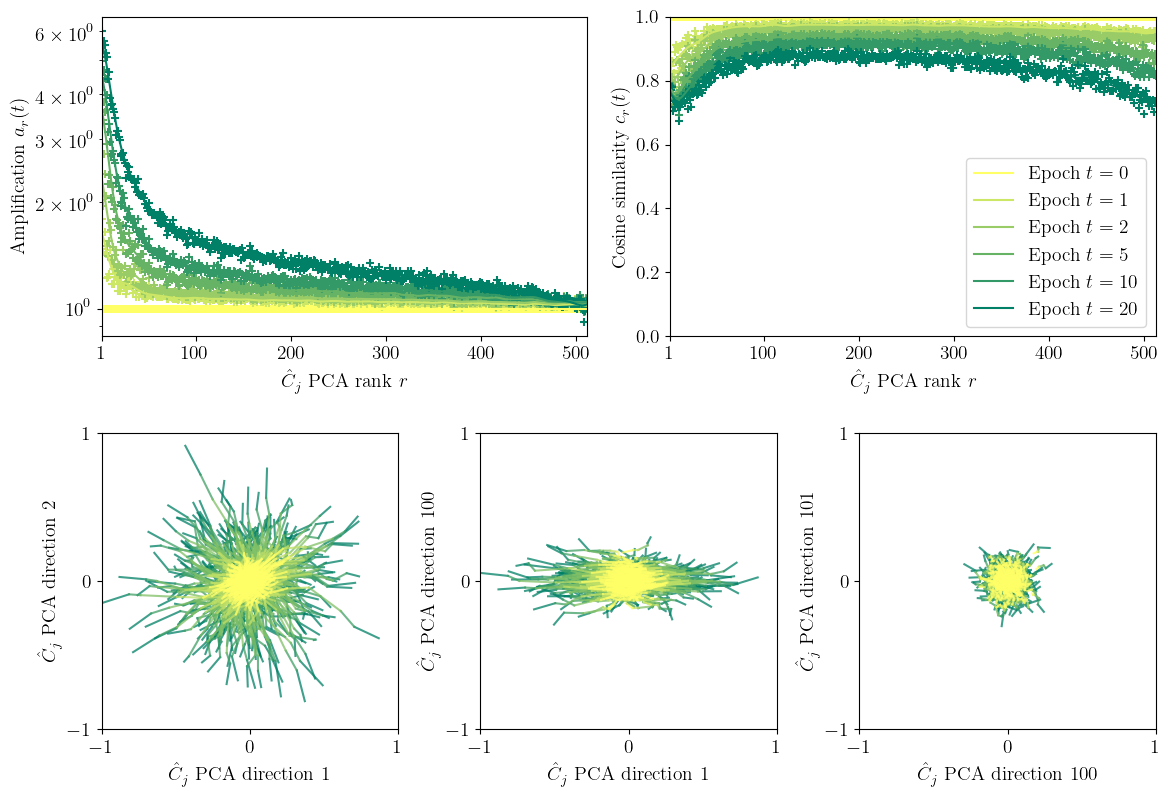

In [7]:
""" Combining amplification and cosine similarity as a function of time + PCA movement. """

subsample_factor = 1

# def change_sizes(sizes, js, s):
#     return [int(size * s) if j in js else size for j, size in enumerate(sizes, start=1)]
# def arch(sizes, std=True):
#     return "W" + "W".join(f"P{size}" if size != "id" else "" for size in sizes) + ("-L4" if std else "-nostd")
# def pattern(sizes=[64, 128, 256, 512], js=[], s=1, std=True):
#     return f"cifar-{arch(change_sizes(sizes, js, s), std=std)}-clbnstd-clnobias-nowd-paperexps-init"

exps_sets = {}
# p = pattern(std=True)
p = "cifar-WP64WP128WP256WP512WP512WP512WP512WP512-L4-clbnstd-clnobias-nowd"
num_exps = 1
exps_dict = exps.load_pattern(p, log=True, full_names=True, num=num_exps)
aligned = AlignedExperiments(exps_dict, recompute=False, batch_size=1024, num_iters=-1)

for j in [4]:  # [1, 2,3, 4, 5, 6, 7]:
    print(f"j = {j}")
    ts = [0, 1, 2, 5, 10, 20]

    amplifications = torch.stack([
        aligned.pca_weight_norm(j=j, key=aligned.key, w_epoch=t, c_epoch=None) / \
        aligned.pca_weight_norm(j=j, key=aligned.key, w_epoch=0, c_epoch=None)  # (R,)
        for t in ts])  # (T, R)
    cosine_sim = torch.stack([
        EuclideanDotProduct().dot(
            aligned.pca_weight_normalized(j=j, key=aligned.key, w_epoch=t, c_epoch=None).T,  # (R, N)
            aligned.pca_weight_normalized(j=j, key=aligned.key, w_epoch=0, c_epoch=None).T,  # (R, N)
            abs=False, batch_axes=1,
        ) for t in ts])  # (T, R)

    colors = list(matplotlib.cm.get_cmap("summer")(np.linspace(0, 1.0, len(ts))))[::-1]

    fig = plt.figure(figsize=(12, 8))
    # subfigs = fig.subfigures(nrows=2)
    subplots = fig.subplot_mosaic("AAABBB;CCDDEE")
    
    d = aligned.exp.num_atoms(j=j)
    step = {1: 5, 2: 25, 3: 50, 4: 100, 5: 100, 6: 100, 7: 100}[j]
    xticks = [1] + [i * step for i in range(1, d // step + 1)]
    
    kwargs = dict(
        xlabel=r"$\hat C_j$ PCA rank $r$", xticks=xticks, xlim=(1, d),
        smoothing=0.01, show_mean=True, show_std=False, show_points=True, 
        has_fig=True, grid=False, colors=colors, subsample_factor=subsample_factor,
    )

    # axs = subfigs[0].subplots(ncols=2)
    # plt.sca(axs[0])
    plt.sca(subplots["A"])
    plot_lines(
        **{f"Epoch $t = {ts[t]}$": amplifications[t] for t in range(len(ts))},
        yscale="log", ylabel="Amplification $a_r(t)$", **kwargs, legend=False,
    )
    # plt.sca(axs[1])
    plt.sca(subplots["B"])
    plot_lines(
        **{f"Epoch $t = {ts[t]}$": cosine_sim[t] for t in range(len(ts))},
        ylim=(0, 1), ylabel="Cosine similarity $c_r(t)$", legend=False, **kwargs,
    )
    plt.legend(loc="lower right")

    # axs = subfigs[1].subplots(ncols=3)
    late = {1: 10, 2: 10, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100}[j]
    for col, dims in enumerate([[1, 2], [1, late], [late, late + 1]]):
    #     plt.sca(axs[col])
        plt.sca(subplots[{0: "C", 1: "D", 2: "E"}[col]])

        weights = torch.stack([aligned.pca_weight(j=j, key=aligned.key, w_epoch=t) for t in ts])  # (T, N, R)
        weights = weights / weights.abs().max()
        
        weights = weights[:, ::subsample_factor, [d - 1 for d in dims]].cpu().numpy()  # (T, N, 2)
        alpha = 0.75
        colors = list(matplotlib.cm.get_cmap("summer")(np.linspace(0, 1.0, len(ts) - 1)))[::-1]

        plt.gca().set_aspect("equal")
        for i in range(len(ts)):
            z = -i
    #         plt.scatter(*weights[i].T, color=colors[i], alpha=alpha, zorder=z, s=0.2)
            if i > 0:
                for k in range(weights.shape[1]):
                    w = weights[[i-1, i], k]  # (2 (t-1, t), 2 (x, y))
                    plt.plot(*w.T, color=colors[i-1], alpha=alpha, zorder=z)
        # plt.axis("off")
        plt.xlim(-1, 1)
        plt.xlabel(fr"$\hat C_j$ PCA direction {dims[0]}")
        plt.xticks([-1, 0, 1])
        plt.ylim(-1, 1)
        plt.ylabel(fr"$\hat C_j$ PCA direction {dims[1]}")
        plt.yticks([-1, 0, 1])

    # fig.tight_layout()
    savefig(f"training_dynamics_j{j}_hat")
    plt.show()